XGBoost (eXtreme Gradient Boosting) is an advanced implementation of gradient boosting modelorithm.

xgboost Advantages:
    
1. Regularization:
Standard GBM implementation has no regularization like XGBoost, therefore it also helps to reduce overfitting.
In fact, XGBoost is also known as ‘regularized boosting‘ technique.

2. Parallel Processing:
XGBoost implements parallel processing and is blazingly faster as compared to GBM.
But hang on, we know that boosting is sequential process so how can it be parallelized? We know that each tree can be built only after the previous one, so what stops us from making a tree using all cores? I hope you get where I’m coming from. Check this link out to explore further.
XGBoost also supports implementation on Hadoop.

3. High Flexibility:
XGBoost allow users to define custom optimization objectives and evaluation criteria.
This adds a whole new dimension to the model and there is no limit to what we can do.

4. Handling Missing Values:
XGBoost has an in-built routine to handle missing values.
User is required to supply a different value than other observations and pass that as a parameter. XGBoost tries different things as it encounters a missing value on each node and learns which path to take for missing values in future.

5. Tree Pruning:
A GBM would stop splitting a node when it encounters a negative loss in the split. Thus it is more of a greedy modelorithm.
XGBoost on the other hand make splits upto the max_depth specified and then start pruning the tree backwards and remove splits beyond which there is no positive gain.
Another advantage is that sometimes a split of negative loss say -2 may be followed by a split of positive loss +10. GBM would stop as it encounters -2. But XGBoost will go deeper and it will see a combined effect of +8 of the split and keep both.

6. Built-in Cross-Validation:
XGBoost allows user to run a cross-validation at each iteration of the boosting process and thus it is easy to get the exact optimum number of boosting iterations in a single run.
This is unlike GBM where we have to run a grid-search and only a limited values can be tested.

7. Continue on Existing Model:
User can start training an XGBoost model from its last iteration of previous run. This can be of significant advantage in certain specific applications.
GBM implementation of sklearn also has this feature so they are even on this point.

[Further Reading](https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/)

In [85]:
#Import libraries:
import pandas as pd
import numpy as np
import xgboost as xgb
from xgboost.sklearn import XGBRegressor
from sklearn import cross_validation, metrics   #Additional scklearn functions
from sklearn.grid_search import GridSearchCV   #Performing grid search

import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 4

## Load Data

In [86]:
house_prices_train = pd.read_csv('train.csv')
house_prices_test = pd.read_csv('test.csv')
house_prices_train.head(2)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500


In [87]:
house_prices_train.shape, house_prices_test.shape

((1460, 81), (1459, 80))

In [88]:
house_prices_all = pd.concat((house_prices_train.loc[:,'MSSubClass':'SaleCondition'], 
                              house_prices_test.loc[:,'MSSubClass':'SaleCondition']))
house_prices_all.head(2)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal


In [89]:
house_prices_train.shape, house_prices_test.shape, house_prices_all.shape

((1460, 81), (1459, 80), (2919, 79))

In [90]:
train = pd.read_csv('train_human_analog.csv')
test = pd.read_csv('test_human_analog.csv')
train.shape, test.shape

((1456, 403), (1459, 403))

In [91]:
train.head(1)

,LotFrontage,LotArea,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,GrLivArea,...,_YearBuiltBin_YearBin7,_YearRemodAddBin_YearBin4,_YearRemodAddBin_YearBin5,_YearRemodAddBin_YearBin6,_YearRemodAddBin_YearBin7,_NeighborhoodBin_0,_NeighborhoodBin_1,_NeighborhoodBin_2,_NeighborhoodBin_3,_NeighborhoodBin_4
0,-0.076848,-0.127817,1.209296,0.625446,-0.355892,-0.339062,-0.472456,-0.80599,1.185669,0.548227,...,1,0,0,0,1,0,0,1,0,0


In [92]:
output = pd.read_csv('output_human_analog.csv', header=None)
output.rename(columns={0: "log_SalePrice"}, inplace=True)
output.drop(0, axis=0, inplace=True)
output.head(2)

,log_SalePrice
1,12.2476991164
2,12.1090164423


In [93]:
train.shape, test.shape, output.shape

((1456, 403), (1459, 403), (1456, 1))

In [94]:
output.dtypes

log_SalePrice    object
dtype: object

In [95]:
output['log_SalePrice'] = output['log_SalePrice'].astype('float64')

In [96]:
output.dtypes

log_SalePrice    float64
dtype: object

## Run xgboost

In [97]:
def modelfit(model, dtrain, features, output, useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    
    if useTrainCV:
        xgb_param = model.get_xgb_params()
        xgtrain = xgb.DMatrix(dtrain[features].values, label=output.values)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=model.get_params()['n_estimators'], nfold=cv_folds,
            metrics='rmse', early_stopping_rounds=early_stopping_rounds, verbose_eval=False)
        model.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the modelorithm on the data
    model.fit(dtrain[features], output, eval_metric='rmse')
        
    #Predict training set:
    dtrain_predictions = model.predict(dtrain[features])
        
    #Print model report:
    print "\nModel Report"
    print "R-Square: %.3f" % metrics.r2_score(output, dtrain_predictions)
    print "RMSE : %.3f" % np.sqrt(metrics.mean_squared_error(output, dtrain_predictions))
    print "Optimal CV Score:" 
    print(cvresult.iloc[len(cvresult)-1,:])
    print "Optimal iteration: %d" %(len(cvresult)-1)
    #print "Cross Validation Result: "
    #print(cvresult)
    
    plt.figure()
    cvresult.loc[:,["test-rmse-mean", "train-rmse-mean"]].plot()
    
    plt.figure()
    feat_imp = pd.Series(model.booster().get_fscore()).sort_values(ascending=False)[0:30] #gets feature_importances ...
    feat_imp.plot(kind='bar', title='Top 30 Feature Importances')
    plt.ylabel('Feature Importance Score')
    return (len(cvresult))

### Step 1: Fix learning rate and number of estimators for tuning tree-based parameters

In [98]:
features = train.columns
features

Index([u'LotFrontage', u'LotArea', u'MasVnrArea', u'BsmtFinSF1', u'BsmtFinSF2',
       u'BsmtUnfSF', u'TotalBsmtSF', u'1stFlrSF', u'2ndFlrSF', u'GrLivArea',
       ...
       u'_YearBuiltBin_YearBin7', u'_YearRemodAddBin_YearBin4',
       u'_YearRemodAddBin_YearBin5', u'_YearRemodAddBin_YearBin6',
       u'_YearRemodAddBin_YearBin7', u'_NeighborhoodBin_0',
       u'_NeighborhoodBin_1', u'_NeighborhoodBin_2', u'_NeighborhoodBin_3',
       u'_NeighborhoodBin_4'],
      dtype='object', length=403)


Model Report
R-Square: 0.997
RMSE : 0.022
Optimal CV Score:
test-rmse-mean     0.122433
test-rmse-std      0.013480
train-rmse-mean    0.018554
train-rmse-std     0.000921
Name: 258, dtype: float64
Optimal iteration: 258


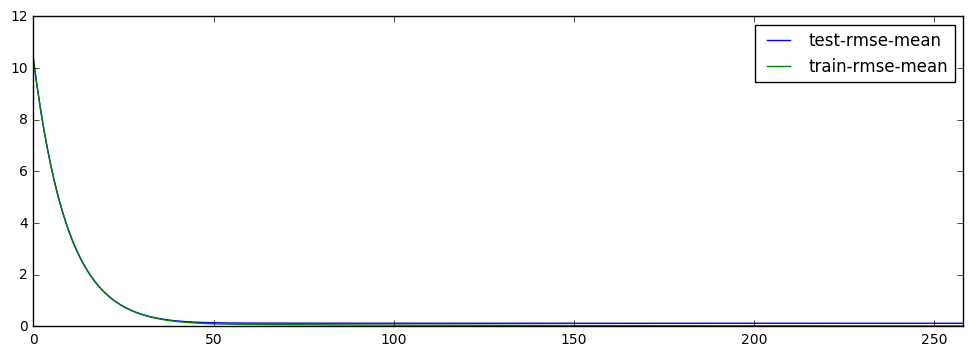

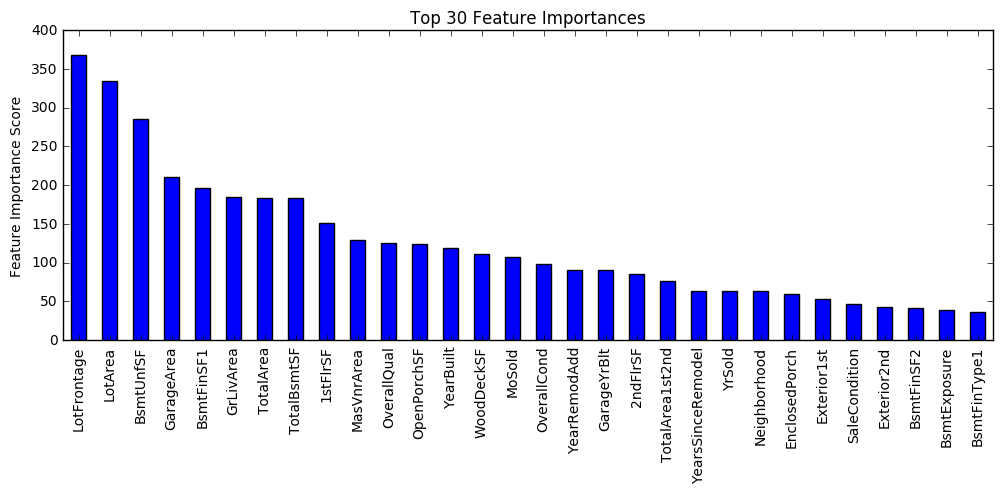

In [99]:
xgb1 = XGBRegressor(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective='reg:linear',
 nthread=4,
 scale_pos_weight=1,
 seed=15)
n_estimators = modelfit(xgb1, train, features, output)

In [100]:
n_estimators

259

### Step 2: Tune max_depth and min_child_weight

1. min_child_weight [default=1]
Defines the minimum sum of weights of all observations required in a child.
This is similar to min_child_leaf in GBM but not exactly. This refers to min “sum of weights” of observations while GBM has min “number of observations”.
Used to control over-fitting. Higher values prevent a model from learning relations which might be highly specific to the particular sample selected for a tree.
Too high values can lead to under-fitting hence, it should be tuned using CV.

2. max_depth [default=6]
The maximum depth of a tree, same as GBM.
Used to control over-fitting as higher depth will allow model to learn relations very specific to a particular sample.
Should be tuned using CV.
Typical values: 3-10

In [101]:
param_test1 = {
 'max_depth': range(2,10,1),
 'min_child_weight': range(1,5,1)
}
gsearch1 = GridSearchCV(estimator = XGBRegressor(
        learning_rate =0.1, 
        n_estimators=n_estimators, 
        gamma=0, 
        subsample=0.8, 
        colsample_bytree=0.8,
        objective= 'reg:linear', 
        nthread=4, 
        scale_pos_weight=1, 
        seed=27), param_grid = param_test1, scoring='mean_squared_error', n_jobs=4,iid=False, cv=5)
gsearch1.fit(train[features],output)
gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

([mean: -0.01338, std: 0.00157, params: {'max_depth': 2, 'min_child_weight': 1},
  mean: -0.01351, std: 0.00136, params: {'max_depth': 2, 'min_child_weight': 2},
  mean: -0.01330, std: 0.00176, params: {'max_depth': 2, 'min_child_weight': 3},
  mean: -0.01306, std: 0.00165, params: {'max_depth': 2, 'min_child_weight': 4},
  mean: -0.01369, std: 0.00136, params: {'max_depth': 3, 'min_child_weight': 1},
  mean: -0.01344, std: 0.00166, params: {'max_depth': 3, 'min_child_weight': 2},
  mean: -0.01337, std: 0.00154, params: {'max_depth': 3, 'min_child_weight': 3},
  mean: -0.01352, std: 0.00163, params: {'max_depth': 3, 'min_child_weight': 4},
  mean: -0.01441, std: 0.00207, params: {'max_depth': 4, 'min_child_weight': 1},
  mean: -0.01384, std: 0.00151, params: {'max_depth': 4, 'min_child_weight': 2},
  mean: -0.01348, std: 0.00211, params: {'max_depth': 4, 'min_child_weight': 3},
  mean: -0.01355, std: 0.00174, params: {'max_depth': 4, 'min_child_weight': 4},
  mean: -0.01461, std: 0.001

In [102]:
gsearch1.best_params_['max_depth'], gsearch1.best_params_['min_child_weight']

(2, 4)

### Step 3: Tune gamma

A node is split only when the resulting split gives a positive reduction in the loss function. Gamma specifies the minimum loss reduction required to make a split.
Makes the algorithm conservative. The values can vary depending on the loss function and should be tuned.

In [103]:
param_test2 = {
 'gamma':[i/10.0 for i in range(0,5)]
}
gsearch2 = GridSearchCV(estimator = XGBRegressor(
        learning_rate =0.1, 
        n_estimators=n_estimators, 
        subsample=0.8, 
        max_depth=gsearch1.best_params_['max_depth'],
        min_child_weight=gsearch1.best_params_['min_child_weight'],
        colsample_bytree=0.8,
        objective= 'reg:linear', 
        nthread=4, 
        scale_pos_weight=1, 
        seed=27), param_grid = param_test2, scoring='mean_squared_error', n_jobs=4,iid=False, cv=5)
gsearch2.fit(train[features],output)
gsearch2.grid_scores_, gsearch2.best_params_, gsearch2.best_score_

([mean: -0.01306, std: 0.00165, params: {'gamma': 0.0},
  mean: -0.01377, std: 0.00139, params: {'gamma': 0.1},
  mean: -0.01520, std: 0.00116, params: {'gamma': 0.2},
  mean: -0.01624, std: 0.00130, params: {'gamma': 0.3},
  mean: -0.01688, std: 0.00148, params: {'gamma': 0.4}],
 {'gamma': 0.0},
 -0.01306202002218489)

### Lets re-calibrate the number of boosting rounds for the updated parameters.


Model Report
R-Square: 0.959
RMSE : 0.080
Optimal CV Score:
test-rmse-mean     0.117401
test-rmse-std      0.010654
train-rmse-mean    0.075648
train-rmse-std     0.001483
Name: 286, dtype: float64
Optimal iteration: 286
Optimal n_estimators: 287


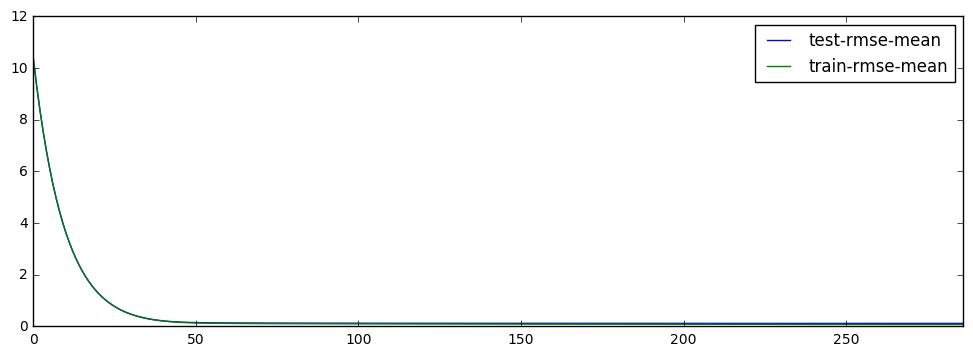

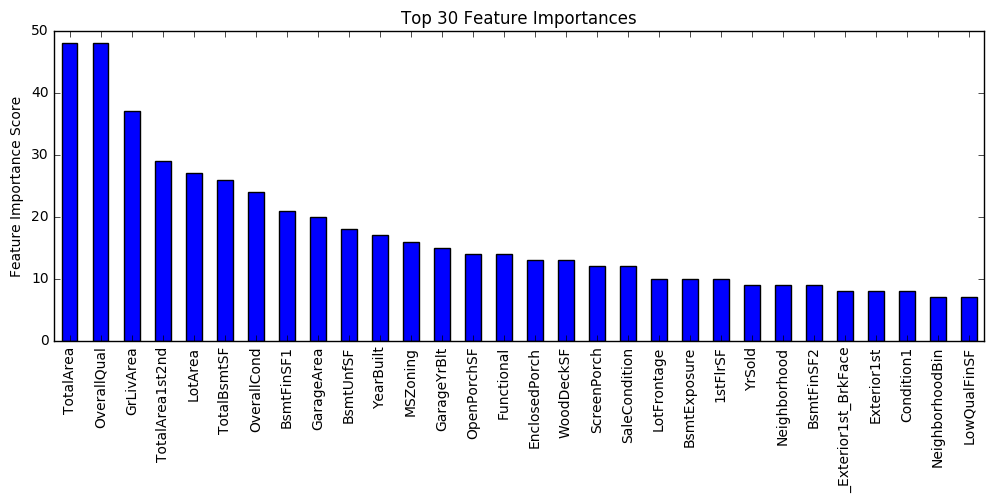

In [104]:
xgb2 = XGBRegressor(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=gsearch1.best_params_['max_depth'],
 min_child_weight=gsearch1.best_params_['min_child_weight'],
 gamma=gsearch2.best_params_['gamma'],
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'reg:linear',
 nthread=4,
 scale_pos_weight=1,
 seed=15)
n_estimators = modelfit(xgb2, train, features, output)
print("Optimal n_estimators: %d") %n_estimators

### Step 4: Tune subsample and colsample_bytree

1. subsample [default=1]
Same as the subsample of GBM. Denotes the fraction of observations to be randomly sampled for each tree.
Lower values make the algorithm more conservative and prevents overfitting but too small values might lead to under-fitting.
Typical values: 0.5-1

2. colsample_bytree [default=1]
Similar to max_features in GBM. Denotes the fraction of columns to be randomly sampled for each tree.
Typical values: 0.5-1

In [105]:
param_test3 = {
 'subsample':[i/10.0 for i in range(6,10)],
 'colsample_bytree':[i/10.0 for i in range(6,10)]
}
gsearch3 = GridSearchCV(estimator = XGBRegressor(
        learning_rate =0.1, 
        n_estimators=n_estimators, 
        gamma=gsearch2.best_params_['gamma'],
        max_depth=gsearch1.best_params_['max_depth'],
        min_child_weight=gsearch1.best_params_['min_child_weight'],
        objective= 'reg:linear', 
        nthread=4, 
        scale_pos_weight=1, 
        seed=27), param_grid = param_test3, scoring='mean_squared_error', n_jobs=4,iid=False, cv=5)
gsearch3.fit(train[features],output)
gsearch3.grid_scores_, gsearch3.best_params_, gsearch3.best_score_

([mean: -0.01314, std: 0.00150, params: {'subsample': 0.6, 'colsample_bytree': 0.6},
  mean: -0.01356, std: 0.00155, params: {'subsample': 0.7, 'colsample_bytree': 0.6},
  mean: -0.01321, std: 0.00138, params: {'subsample': 0.8, 'colsample_bytree': 0.6},
  mean: -0.01312, std: 0.00148, params: {'subsample': 0.9, 'colsample_bytree': 0.6},
  mean: -0.01336, std: 0.00126, params: {'subsample': 0.6, 'colsample_bytree': 0.7},
  mean: -0.01342, std: 0.00156, params: {'subsample': 0.7, 'colsample_bytree': 0.7},
  mean: -0.01325, std: 0.00147, params: {'subsample': 0.8, 'colsample_bytree': 0.7},
  mean: -0.01343, std: 0.00174, params: {'subsample': 0.9, 'colsample_bytree': 0.7},
  mean: -0.01352, std: 0.00113, params: {'subsample': 0.6, 'colsample_bytree': 0.8},
  mean: -0.01334, std: 0.00132, params: {'subsample': 0.7, 'colsample_bytree': 0.8},
  mean: -0.01301, std: 0.00168, params: {'subsample': 0.8, 'colsample_bytree': 0.8},
  mean: -0.01345, std: 0.00188, params: {'subsample': 0.9, 'colsa

Lets try this again for a more granular values.

In [106]:
features = train.columns
param_test4 = {
 'subsample':[i/100.0 for i in range(50,100,5)],
 'colsample_bytree':[i/100.0 for i in range(50,100,5)]
}
gsearch4 = GridSearchCV(estimator = XGBRegressor(
        learning_rate =0.1, 
        n_estimators=n_estimators, 
        gamma=gsearch2.best_params_['gamma'],
        max_depth=gsearch1.best_params_['max_depth'],
        min_child_weight=gsearch1.best_params_['min_child_weight'],
        objective= 'reg:linear', 
        nthread=4, 
        scale_pos_weight=1, 
        seed=27), param_grid = param_test4, scoring='mean_squared_error', n_jobs=4,iid=False, cv=5)
gsearch4.fit(train[features],output)
gsearch4.grid_scores_, gsearch4.best_params_, gsearch4.best_score_

([mean: -0.01332, std: 0.00081, params: {'subsample': 0.5, 'colsample_bytree': 0.5},
  mean: -0.01324, std: 0.00111, params: {'subsample': 0.55, 'colsample_bytree': 0.5},
  mean: -0.01356, std: 0.00141, params: {'subsample': 0.6, 'colsample_bytree': 0.5},
  mean: -0.01310, std: 0.00142, params: {'subsample': 0.65, 'colsample_bytree': 0.5},
  mean: -0.01335, std: 0.00181, params: {'subsample': 0.7, 'colsample_bytree': 0.5},
  mean: -0.01306, std: 0.00134, params: {'subsample': 0.75, 'colsample_bytree': 0.5},
  mean: -0.01303, std: 0.00128, params: {'subsample': 0.8, 'colsample_bytree': 0.5},
  mean: -0.01328, std: 0.00157, params: {'subsample': 0.85, 'colsample_bytree': 0.5},
  mean: -0.01328, std: 0.00166, params: {'subsample': 0.9, 'colsample_bytree': 0.5},
  mean: -0.01333, std: 0.00143, params: {'subsample': 0.95, 'colsample_bytree': 0.5},
  mean: -0.01313, std: 0.00118, params: {'subsample': 0.5, 'colsample_bytree': 0.55},
  mean: -0.01322, std: 0.00123, params: {'subsample': 0.55,

### Step 5: Tuning Regularization Parameters

1. alpha [default=0]
L1 regularization term on weight (analogous to Lasso regression)
Can be used in case of very high dimensionality so that the algorithm runs faster when implemented

2. lambda [default=1]
L2 regularization term on weights (analogous to Ridge regression)
This used to handle the regularization part of XGBoost. Though many data scientists don’t use it often, it should be explored to reduce overfitting.

In [107]:
param_test5 = {
 'reg_alpha':np.arange(0.01, 1, 0.01)
}
gsearch5 = GridSearchCV(estimator = XGBRegressor(
        learning_rate =0.1, 
        n_estimators=n_estimators, 
        gamma=gsearch2.best_params_['gamma'],
        max_depth=gsearch1.best_params_['max_depth'],
        min_child_weight=gsearch1.best_params_['min_child_weight'],
        objective= 'reg:linear',
        subsample=gsearch4.best_params_['subsample'],
        colsample_bytree=gsearch4.best_params_['colsample_bytree'],
        nthread=4, 
        scale_pos_weight=1, 
        seed=27), param_grid = param_test5, scoring='mean_squared_error', n_jobs=4,iid=False, cv=5)
gsearch5.fit(train[features],output)
gsearch5.grid_scores_, gsearch5.best_params_, gsearch5.best_score_

([mean: -0.01282, std: 0.00133, params: {'reg_alpha': 0.01},
  mean: -0.01295, std: 0.00132, params: {'reg_alpha': 0.02},
  mean: -0.01305, std: 0.00119, params: {'reg_alpha': 0.029999999999999999},
  mean: -0.01292, std: 0.00133, params: {'reg_alpha': 0.040000000000000001},
  mean: -0.01291, std: 0.00131, params: {'reg_alpha': 0.050000000000000003},
  mean: -0.01296, std: 0.00121, params: {'reg_alpha': 0.060000000000000005},
  mean: -0.01300, std: 0.00117, params: {'reg_alpha': 0.069999999999999993},
  mean: -0.01310, std: 0.00128, params: {'reg_alpha': 0.080000000000000002},
  mean: -0.01312, std: 0.00135, params: {'reg_alpha': 0.089999999999999997},
  mean: -0.01307, std: 0.00139, params: {'reg_alpha': 0.099999999999999992},
  mean: -0.01314, std: 0.00147, params: {'reg_alpha': 0.11},
  mean: -0.01306, std: 0.00129, params: {'reg_alpha': 0.12},
  mean: -0.01303, std: 0.00140, params: {'reg_alpha': 0.13},
  mean: -0.01290, std: 0.00133, params: {'reg_alpha': 0.14000000000000001},
  m

In [120]:
param_test7 = {
 'reg_lambda':np.arange(0.8,1.5,0.01)
}
gsearch7 = GridSearchCV(estimator = XGBRegressor(
        learning_rate =0.1, 
        n_estimators=n_estimators, 
        gamma=gsearch2.best_params_['gamma'],
        max_depth=gsearch1.best_params_['max_depth'],
        min_child_weight=gsearch1.best_params_['min_child_weight'],
        reg_alpha=gsearch5.best_params_['reg_alpha'],
        objective='reg:linear',
        subsample=gsearch4.best_params_['subsample'],
        colsample_bytree=gsearch4.best_params_['colsample_bytree'],
        nthread=4, 
        scale_pos_weight=1, 
        seed=27), param_grid = param_test7, scoring='mean_squared_error', n_jobs=4,iid=False, cv=5)
gsearch7.fit(train[features],output)
gsearch7.grid_scores_, gsearch7.best_params_, gsearch7.best_score_

([mean: -0.01277, std: 0.00137, params: {'reg_lambda': 0.80000000000000004},
  mean: -0.01287, std: 0.00142, params: {'reg_lambda': 0.81000000000000005},
  mean: -0.01295, std: 0.00144, params: {'reg_lambda': 0.82000000000000006},
  mean: -0.01289, std: 0.00141, params: {'reg_lambda': 0.83000000000000007},
  mean: -0.01284, std: 0.00127, params: {'reg_lambda': 0.84000000000000008},
  mean: -0.01292, std: 0.00134, params: {'reg_lambda': 0.85000000000000009},
  mean: -0.01290, std: 0.00133, params: {'reg_lambda': 0.8600000000000001},
  mean: -0.01297, std: 0.00143, params: {'reg_lambda': 0.87000000000000011},
  mean: -0.01285, std: 0.00136, params: {'reg_lambda': 0.88000000000000012},
  mean: -0.01291, std: 0.00139, params: {'reg_lambda': 0.89000000000000012},
  mean: -0.01296, std: 0.00145, params: {'reg_lambda': 0.90000000000000013},
  mean: -0.01289, std: 0.00135, params: {'reg_lambda': 0.91000000000000014},
  mean: -0.01277, std: 0.00128, params: {'reg_lambda': 0.92000000000000015},



Model Report
R-Square: 0.958
RMSE : 0.082
Optimal CV Score:
test-rmse-mean     0.115033
test-rmse-std      0.010829
train-rmse-mean    0.078688
train-rmse-std     0.002156
Name: 402, dtype: float64
Optimal iteration: 402


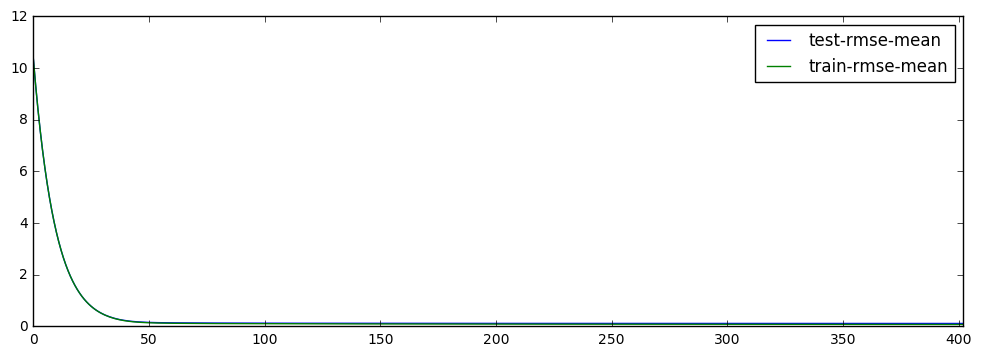

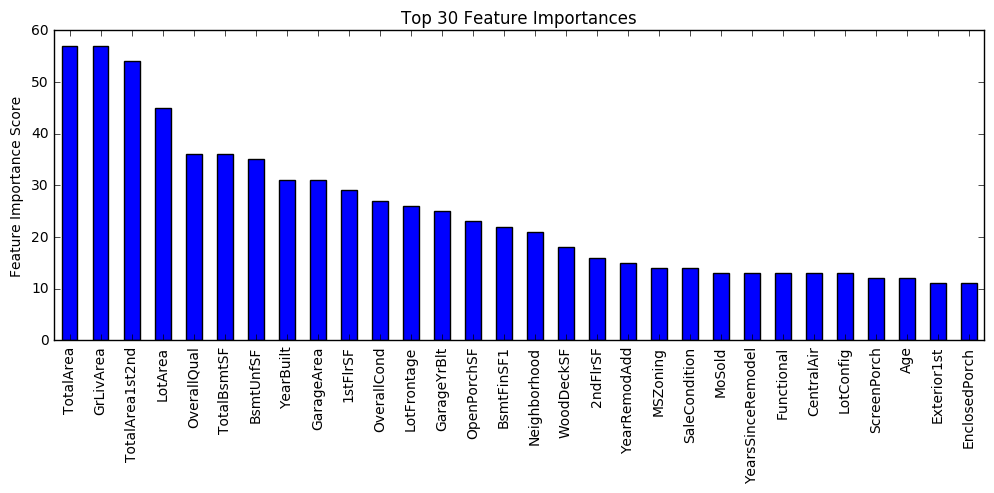

In [121]:
xgb3 = XGBRegressor(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=gsearch1.best_params_['max_depth'],
 min_child_weight=gsearch1.best_params_['min_child_weight'],
 reg_alpha=gsearch5.best_params_['reg_alpha'],
 reg_lambda=gsearch7.best_params_['reg_lambda'],
 gamma=gsearch2.best_params_['gamma'],
 subsample=gsearch4.best_params_['subsample'],
 colsample_bytree=gsearch4.best_params_['colsample_bytree'],
 objective= 'reg:linear',
 nthread=4,
 scale_pos_weight=1,
 seed=15)
n_estimators = modelfit(xgb3, train, features, output)

### Step 6: Reducing Learning Rate

In [122]:
n_estimators

403


Model Report
R-Square: 0.955
RMSE : 0.084
Optimal CV Score:
test-rmse-mean     0.112844
test-rmse-std      0.011960
train-rmse-mean    0.080763
train-rmse-std     0.002172
Name: 3222, dtype: float64
Optimal iteration: 3222


3223

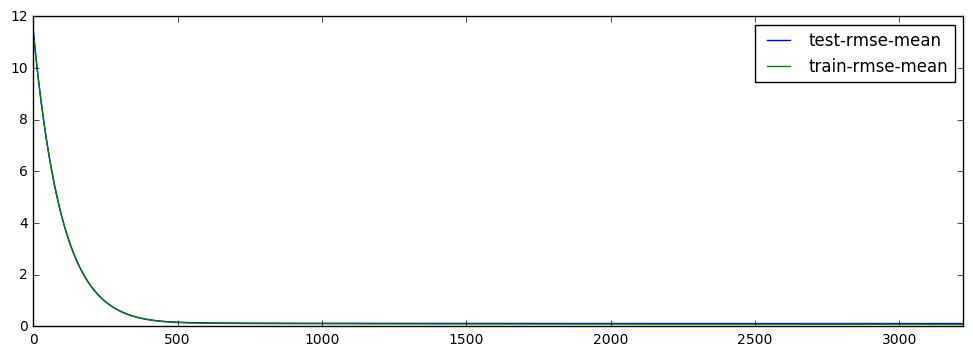

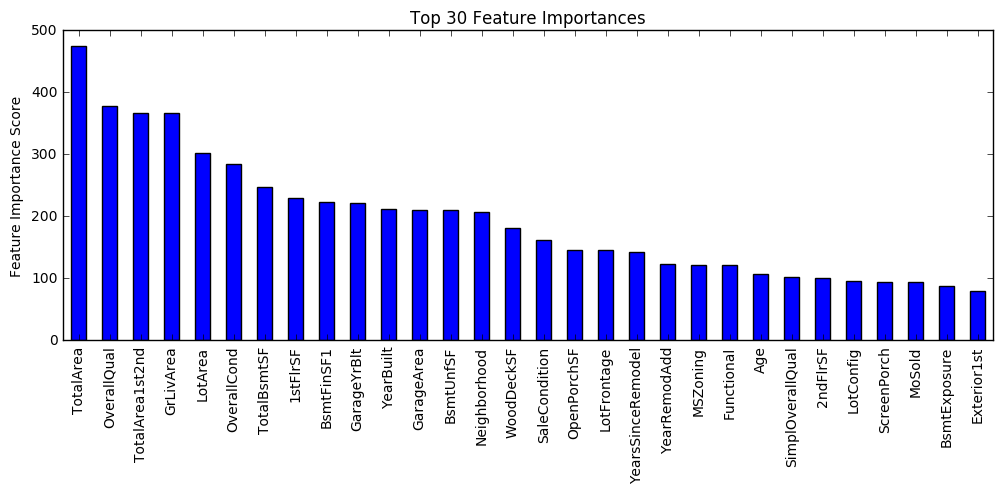

In [123]:
xgb4 = XGBRegressor(
 learning_rate =0.01,
 n_estimators=10000,
 max_depth=gsearch1.best_params_['max_depth'],
 min_child_weight=gsearch1.best_params_['min_child_weight'],
 reg_alpha=gsearch5.best_params_['reg_alpha'],
 reg_lambda=gsearch7.best_params_['reg_lambda'],
 gamma=gsearch2.best_params_['gamma'],
 subsample=gsearch4.best_params_['subsample'],
 colsample_bytree=gsearch4.best_params_['colsample_bytree'],
 objective= 'reg:linear',
 nthread=4,
 scale_pos_weight=1,
 seed=15)
modelfit(xgb4, train, features, output)

In [124]:
pred = xgb4.predict(test)
xgb_prediction_1 = pd.DataFrame({'Id': house_prices_test['Id'], 'SalePrice': pred})
xgb_prediction_1.head(5)

,Id,SalePrice
0,1461,11.731744
1,1462,11.994186
2,1463,12.098763
3,1464,12.153595
4,1465,12.175338


In [125]:
#xgb_prediction_1.to_csv('kaggle_submission_xgb4_12242016.csv', index=False)

In [139]:
param_test8 = {
 'learning_rate':np.arange(0.001,0.003,0.0005),
 'n_estimators': np.arange(10000,15000,2000)
}
gsearch8 = GridSearchCV(estimator = XGBRegressor( 
        gamma=gsearch2.best_params_['gamma'],
        max_depth=gsearch1.best_params_['max_depth'],
        min_child_weight=gsearch1.best_params_['min_child_weight'],
        reg_alpha=gsearch5.best_params_['reg_alpha'],
        reg_lambda=gsearch7.best_params_['reg_lambda'],
        objective='reg:linear',
        subsample=gsearch4.best_params_['subsample'],
        colsample_bytree=gsearch4.best_params_['colsample_bytree'],
        nthread=4, 
        scale_pos_weight=1, 
        seed=27), param_grid = param_test8, scoring='mean_squared_error', n_jobs=4,iid=False, cv=5)
gsearch8.fit(train[features],output)
gsearch8.grid_scores_, gsearch8.best_params_, gsearch8.best_score_

([mean: -0.01468, std: 0.00128, params: {'n_estimators': 10000, 'learning_rate': 0.001},
  mean: -0.01404, std: 0.00127, params: {'n_estimators': 12000, 'learning_rate': 0.001},
  mean: -0.01359, std: 0.00124, params: {'n_estimators': 14000, 'learning_rate': 0.001},
  mean: -0.01340, std: 0.00119, params: {'n_estimators': 10000, 'learning_rate': 0.0015},
  mean: -0.01302, std: 0.00117, params: {'n_estimators': 12000, 'learning_rate': 0.0015},
  mean: -0.01278, std: 0.00114, params: {'n_estimators': 14000, 'learning_rate': 0.0015},
  mean: -0.01284, std: 0.00117, params: {'n_estimators': 10000, 'learning_rate': 0.002},
  mean: -0.01261, std: 0.00115, params: {'n_estimators': 12000, 'learning_rate': 0.002},
  mean: -0.01248, std: 0.00114, params: {'n_estimators': 14000, 'learning_rate': 0.002},
  mean: -0.01257, std: 0.00117, params: {'n_estimators': 10000, 'learning_rate': 0.0025000000000000001},
  mean: -0.01244, std: 0.00115, params: {'n_estimators': 12000, 'learning_rate': 0.00250000


Model Report
R-Square: 0.956
RMSE : 0.083
Optimal CV Score:
test-rmse-mean     0.112688
test-rmse-std      0.011846
train-rmse-mean    0.080789
train-rmse-std     0.002154
Name: 12807, dtype: float64
Optimal iteration: 12807


12808

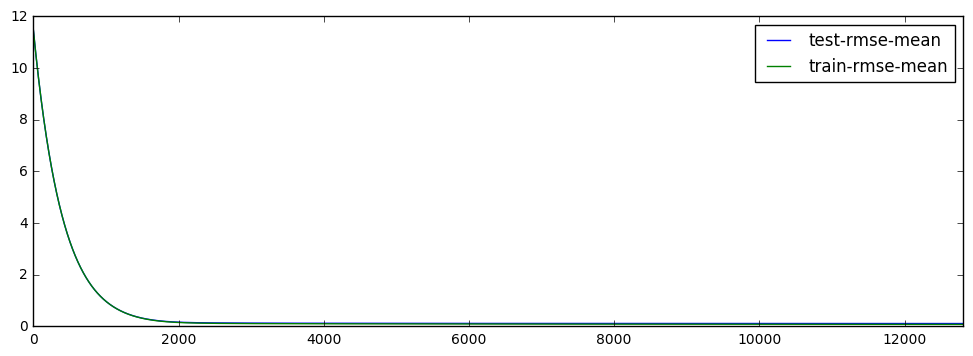

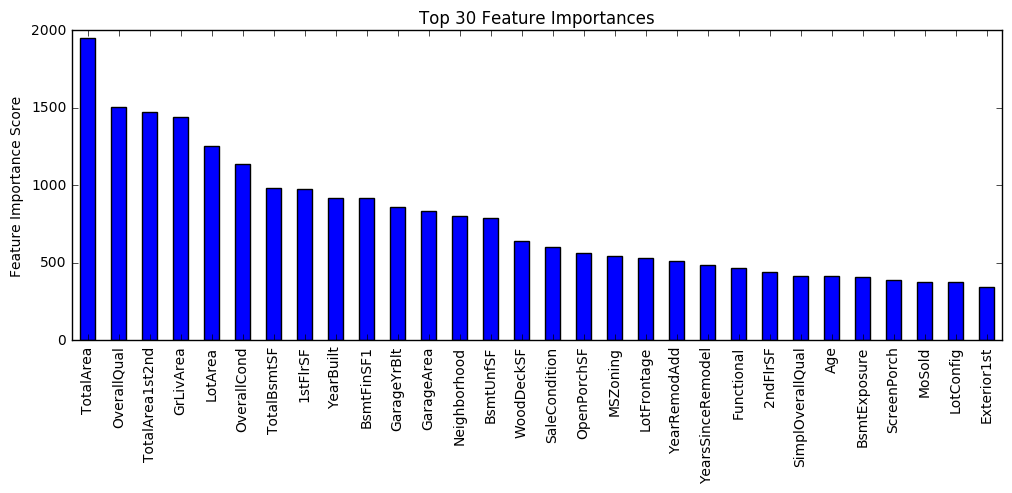

In [140]:
xgb5 = XGBRegressor(
 learning_rate =0.0025,
 n_estimators=20000,
 max_depth=gsearch1.best_params_['max_depth'],
 min_child_weight=gsearch1.best_params_['min_child_weight'],
 reg_alpha=gsearch5.best_params_['reg_alpha'],
 reg_lambda=gsearch7.best_params_['reg_lambda'],
 gamma=gsearch2.best_params_['gamma'],
 subsample=gsearch4.best_params_['subsample'],
 colsample_bytree=gsearch4.best_params_['colsample_bytree'],
 objective= 'reg:linear',
 nthread=4,
 scale_pos_weight=1,
 seed=15)
modelfit(xgb5, train, features, output)

In [141]:
pred = np.expm1(xgb5.predict(test))
xgb5_prediction = pd.DataFrame({'Id': house_prices_test['Id'], 'SalePrice': pred})
xgb5_prediction.head(5)

,Id,SalePrice
0,1461,124752.679688
1,1462,160418.265625
2,1463,181702.453125
3,1464,191122.484375
4,1465,193343.500000


In [142]:
xgb5_prediction.to_csv('kaggle_submission_xgb_01022017.csv', index=False)

In [143]:
lasso_pred = pd.read_csv('kaggle_submission_lasso_01012017.csv')
print lasso_pred['SalePrice'].values
xgb_lasso = (lasso_pred['SalePrice'].values + pred) * 0.5

[ 121731.81554   156388.629001  179713.188227 ...,  163970.804772
  117051.730715  220868.783804]


In [144]:
xgb_lasso_prediction = pd.DataFrame({'Id': house_prices_test['Id'], 'SalePrice': xgb_lasso})
xgb_lasso_prediction.head(5)

,Id,SalePrice
0,1461,123242.247614
1,1462,158403.447313
2,1463,180707.820676
3,1464,193814.130799
4,1465,196095.178217


In [145]:
#xgb_lasso_prediction.to_csv('kaggle_submission_xgb_lasso_01022017.csv', index=False)

In [146]:
gbm_pred = pd.read_csv('kaggle_submission_gbm5_12202016.csv')
print gbm_pred['SalePrice'].values

[ 122035.292708  160532.645518  184200.397737 ...,  164693.366381
  119815.208918  216467.061368]


In [156]:
gbm_lasso = (lasso_pred['SalePrice'].values * 0.6 + gbm_pred['SalePrice'].values * 0.4)

In [157]:
gbm_lasso_prediction = pd.DataFrame({'Id': house_prices_test['Id'], 'SalePrice': gbm_lasso})
gbm_lasso_prediction.head(5)

,Id,SalePrice
0,1461,121853.206407
1,1462,158046.235608
2,1463,181508.072031
3,1464,196064.548829
4,1465,196269.012827


In [158]:
gbm_lasso_prediction.to_csv('kaggle_submission_gbm_lasso_01022017.csv', index=False)

In [153]:
gbm_xgb_lasso = (lasso_pred['SalePrice'].values * 0.6 + gbm_pred['SalePrice'].values * 0.3 + pred * 0.1)

In [154]:
gbm_xgb_lasso_prediction = pd.DataFrame({'Id': house_prices_test['Id'], 'SalePrice': gbm_xgb_lasso})

In [155]:
gbm_xgb_lasso_prediction.to_csv('kaggle_submission_gbm_xgb_lasso_01022017.csv', index=False)